# Introduction to Data Analysis
## HSE, 2020-2021 academic year

### Homework 8

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBClassifier
import catboost
from matplotlib import pylab as plt
%pylab inline
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress = True)   

Populating the interactive namespace from numpy and matplotlib


/Users/nikitadvornov/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Gradient boosting with your own hands (2 + 2* points)

Implement a gradient boosting algorithm for regression. Let's recall the basic formulas.

Let's denote the current composition in $N-1$ steps by $a_{N - 1}(x_i)$. The following basic algorithm is $b_N(x_i)$ is trained on the answers $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, where $L(y_i, z)$ is the value of the loss function on the object with the correct answer $y_i$ and the prediction of $z$. The composition in the next step is obtained as follows:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Here $\nu$ is the learning rate hyperparameter, $\gamma_N$ is the optimal weight, adjusted at each step of the algorithm, which can be found using the following formula (note the absence of $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

You can take $\gamma_N = 1$ for each $N$. Implement finding the optimal $\gamma_N$ at each step to get 1 more point.

Take MSE as a loss function.

*Note. You can use the `DecisionTree` from `sklearn` and optimization methods from various libraries.*

In [9]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [27]:
# без подбора gamma
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate

        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        self.trees_ = []
        prediction = np.mean(y) * np.ones([y.shape[0]])
        for i in tqdm(range(self.n_estimators)):
            y_new = y - prediction # антиградиент
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            self.trees_.append(tree)
            prediction = np.sum([prediction, self._fit_predict_tree(x, y_new)], axis=0)
        return self


    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        self.trees_[-1].fit(x, y)
        return self.learning_rate * self.trees_[-1].predict(x)
        
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        pred = np.ones([x.shape[0]]) * np.mean(y)
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(x).reshape([x.shape[0]])
        return pred

In [29]:
# с подбором gamma
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = 0.5
        

    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        self.trees_ = []
        prediction = np.mean(y) * np.ones([y.shape[0]])
        for i in tqdm(range(self.n_estimators)):
            y_new = y - prediction # антиградиент
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            self.trees_.append(tree)
            prediction = np.sum([prediction, self._fit_predict_tree(x, y_new)], axis=0)
        return self
    

    def _fit_predict_tree(self, x, y):
        def gamma_determinator(gamma, y, last_model_prediction):
            return mean_squared_error(y, gamma * last_model_prediction)
        # Обучаем дерево и возвращаем его предикшн
        self.trees_[-1].fit(x, y)
        minim = minimize(gamma_determinator, x0=5, args=(y, self.trees_[-1].predict(x)))
        self.gamma = minim.x
        return self.gamma * self.learning_rate * self.trees_[-1].predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        pred = np.ones([x.shape[0]]) * np.mean(y)
        for t in range(self.n_estimators):
            pred += self.gamma * self.learning_rate * self.trees_[t].predict(x).reshape([x.shape[0]])
        return pred

Check your implementation on the Boston dataset. Choose optimal hyperparameters to defeat RandomForestRegressor both in the usual case and when finding the optimal step **(do not change the parameters of the seed)**. If necessary, use `Grid Search`. You will get 1 more point for this.

In [5]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [28]:
# without gamma
np.random.seed(19052019)
gb = GradientBoosting(700, 8, 0.341)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

100%|██████████| 700/700 [00:01<00:00, 524.47it/s]


9.490703904358877

In [57]:
# with gamma
np.random.seed(19052019)
gb = GradientBoosting(700, 6, 0.0205508)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

100%|██████████| 700/700 [00:02<00:00, 241.76it/s]


9.969052219314307

For the convenience of the examiner, please indicate whether you have implemented finding the optimal step.

- yes!

## Predicting aircraft delays (2 points)

Let's work on the problem of aircraft delays. Based on the available flight data, you need to determine if it will be delayed by 15 minutes.
Use any gradient boosting methods `XGboost`, `catboost`, `LightGBM` and GridSearch to achieve the result. Get 1 point for breaking the roc_auc_score threshold of 0.72 and another 1 point for breaking the threshold of 0.74.

In [36]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [37]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [38]:
labelencoder = LabelEncoder()
for i in range(8):
    train.iloc[:, i] = labelencoder.fit_transform(train.iloc[:, i])
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,10,13,6,1017,0,18,78,577,N
1,6,12,2,791,18,217,171,651,N
2,11,11,4,705,20,228,59,306,N
3,2,17,5,458,15,78,175,683,N
4,1,28,5,951,19,174,199,313,Y


In [39]:
# Референс
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values # зачем он нам?
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier()
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.6993352215114426

In [40]:
X_train = train.drop('dep_delayed_15min', axis=1).values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

In [41]:
cat_features = list(range(0, X_train.shape[1]))

In [42]:
print('Labels: {}'.format(set(y_train)))
print('Zero count = {}, One count = {}'.format(len(y_train) - sum(y_train), sum(y_train)))

Labels: {0, 1}
Zero count = 80956, One count = 19044


In [43]:
pool1 = Pool(data=X_train, label=y_train, cat_features=cat_features)

In [44]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [45]:
model = CatBoostClassifier(iterations=500, learning_rate=0.1, early_stopping_rounds=20)
model.fit(X_train_part, y_train_part, cat_features=cat_features, 
          eval_set=(X_valid, y_valid), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [46]:
cv = KFold(n_splits=4, random_state=10, shuffle=True)

In [155]:
hyperparams_catboost = {'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2], 'depth': [1, 3, 5, 10], 'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']}
grid_catboost = GridSearchCV(model, hyperparams_catboost, cv=cv, verbose=1, n_jobs=-1)
grid_catboost_fitted = grid_catboost.fit(X_train_part, y_train_part)

In [55]:
# считается по сетке доллго (минут 45, но в итоге лучшие параметры такие)
print(grid_catboost_fitted.best_params_) # {'depth': 10, 'grow_policy': 'Lossguide', 'learning_rate': 0.1}

{'depth': 5, 'grow_policy': 'Lossguide', 'learning_rate': 0.1}


In [53]:
model_best = CatBoostClassifier(learning_rate=0.1, depth=10, grow_policy='Lossguide', verbose=False, random_state=33)
model_best.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, model_best.predict_proba(X_valid)[:, 1])

0.7407105343002928

## DBSCAN with your own hands (2 + 2* points)

DBSCAN: Density-based spatial clustering of applications with noise

Implement the dbscan class.

The algorithm has two main hyperparameters:
1. `eps` - the radius of the neighborhood in question
2. `min_samples` - the number of neighbors in the neighborhood

To perform DBSCAN clustering, the points are divided into main points, achievable by point density, and drop-down points as follows:

- The point $p$ is the main point if at least `min_samples` of the points are located at a distance not exceeding 
`eps` from her. These points are said to be achievable directly from $p$.

- A point $q$ is directly reachable from $p$ if the point $q$ is located at a distance of no more than `eps` from the point $p$, and $p$ is the main point.
The point $q$ is reachable from $p$ if there is a path 
$p_1,...,p_n$ where $p_1=p$ and $p_n=q$ , and each point $p_{i+1}$ is reachable directly from $p_i$ (all points on the path must be primary, except for $q$).

All points that are not reachable from the main points are considered outliers.

Now, if $p$ is the main point, then it forms a cluster together with all the points (main or non-main) reachable from this point. Each cluster contains at least one main point. Non-primary points can be part of a cluster, but they form its "edge" because they cannot be used to reach other points.

In [54]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [56]:
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples 
    
    def fit_predict(self, X):
        self.X = X
        self.clusters = []
        self.visited_samples = []
        self.neighbors = {}
        n_samples = np.shape(self.X)[0]
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        for sample_i in range(n_samples):
            if sample_i in self.visited_samples:
                continue
            self.neighbors[sample_i] = self.range_query(sample_i)
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
            if len(self.neighbors[sample_i]) >= self.min_samples:
                self.visited_samples.append(sample_i)
                new_cluster = self.grow_cluster(sample_i, self.neighbors[sample_i])
                self.clusters.append(new_cluster)
        cluster_labels = self.cluster_labels()
        return cluster_labels
        
    def grow_cluster(self, root, neighbors):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        cluster = [root]
        for neighbor in neighbors:
            if not neighbor in self.visited_samples:
                self.visited_samples.append(neighbor)
                self.neighbors[neighbor] = self.range_query(neighbor)
                if len(self.neighbors[neighbor]) >= self.min_samples:
                    wider_cluster = self.grow_cluster(neighbor, self.neighbors[neighbor])
                    cluster = cluster + wider_cluster
                else:
                    cluster.append(neighbor)
        return cluster

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        neighbors = []
        for sample in range(self.X.shape[0]):
            if self.dist(self.X[x], self.X[sample]) <= self.eps:
                neighbors.append(sample)
        return np.array(neighbors)

    def cluster_labels(self):
        """ Для покраски точек """
        labels = np.full(shape=self.X.shape[0], fill_value=len(self.clusters))
        for cluster_i, cluster in enumerate(self.clusters):
            for sample_i in cluster:
                labels[sample_i] = cluster_i
        return labels
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        return distance.euclidean(a, b)
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика

Let's test ourselves with a simple example:

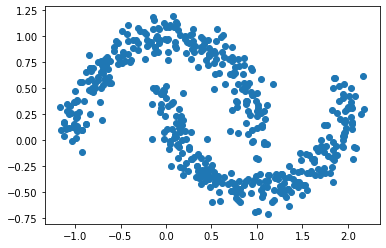

In [57]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1, random_state=10)
plt.scatter(X[:,0], X[:,1])
plt.show()

Cluster this using your version of DBSCAN:

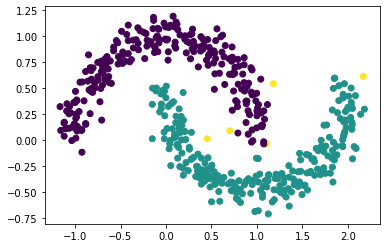

In [58]:
clusters = dbscan(eps=0.17, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

The reference:

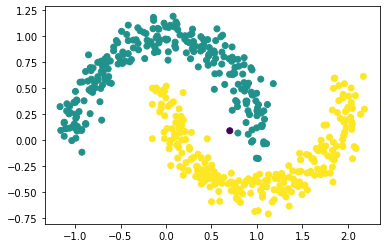

In [59]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.18, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Get 1 point for another interesting clustering example (use the provided image as a reference. We need some interesting neighboring shapes):

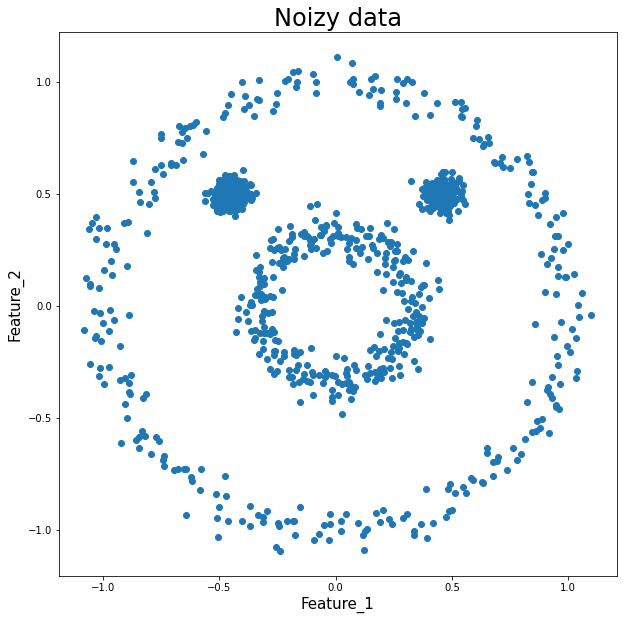

In [63]:
from sklearn import datasets
from sklearn.datasets import make_blobs, make_circles

circles, circle_labels = make_circles(n_samples=600, factor=0.33, noise=0.05, random_state=10) 
blobs, blob_labels = make_blobs(n_samples=500, centers=[[0.45, 0.5], [-0.45, 0.5]], 
                                cluster_std=[[0.04], [0.04]], random_state=10) 
 
X = np.concatenate((circles, blobs)) 

plt.figure(figsize=(10, 10)) 
plt.scatter(X[:, 0], X[:, 1])
plt.title('Noizy data', fontsize=24)
plt.xlabel('Feature_1', fontsize=15)
plt.ylabel('Feature_2', fontsize=15)
plt.show()

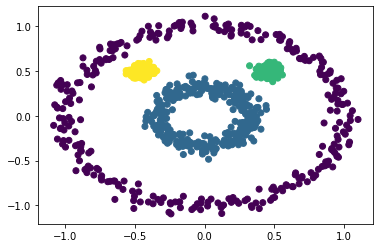

In [66]:
clusters = dbscan(eps=0.13, min_samples=5).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Get another 1 point if your algorithm's running time is no more than 20% more than the reference time:

In [26]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 9.24 ms, sys: 2.07 ms, total: 11.3 ms
Wall time: 8.99 ms


In [27]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 2.26 s, sys: 10.7 ms, total: 2.27 s
Wall time: 2.28 s
